## HW 4: Policy gradient
_Reference: based on Practical RL course by YSDA_

In this notebook you have to master Policy gradient Q-learning and apply it to familiar (and not so familiar) RL problems once again.

To get used to `gymnasium` package, please, refer to the [documentation](https://gymnasium.farama.org/introduction/basic_usage/).


In the end of the notebook, please, copy the functions you have implemented to the template file and submit it to the Contest.

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

d:\Python 3.12.4 amd64\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


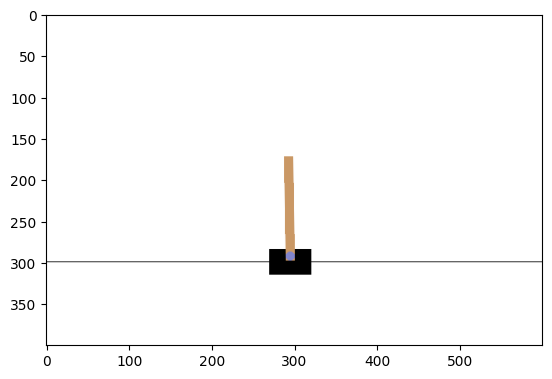

In [2]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render())

# Building the network for Policy Gradient (REINFORCE)

For REINFORCE algorithm, we'll need a model that predicts action probabilities given states.

For numerical stability, please __do not include the softmax layer into your network architecture__.
We'll use softmax or log-softmax where appropriate.

In [3]:
import torch
import torch.nn as nn

In [4]:
# Build a simple neural network that predicts policy logits
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, n_actions, hidden_size=64):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim[0], hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, n_actions)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # logits, not probabilities
        return x

# Create the model
model = PolicyNetwork(state_dim, n_actions)
print(f"Model created with {state_dim[0]} inputs and {n_actions} outputs")

# Test the model
test_state = torch.tensor(env.reset()[0], dtype=torch.float32).unsqueeze(0)
logits = model(test_state)
print(f"Test logits shape: {logits.shape}")
print(f"Test logits: {logits}")

assert model is not None, "model is not defined"
print("Model assertion passed!")

Model created with 4 inputs and 2 outputs
Test logits shape: torch.Size([1, 2])
Test logits: tensor([[0.1115, 0.1104]], grad_fn=<AddmmBackward0>)
Model assertion passed!


In [5]:
# do not change the code block below
batch_size_for_test = 5
example_states_batch = np.array([env.reset()[0] for _ in range(5)])
print(f"example_states_batch.shape: {example_states_batch.shape}")
assert example_states_batch.shape == (batch_size_for_test, state_dim[0])

example_logits = model(torch.from_numpy(example_states_batch))
print(f"example_logits.shape: {example_logits.shape}")
assert example_logits.shape == (batch_size_for_test, n_actions)
# do not change the code block above

example_states_batch.shape: (5, 4)
example_logits.shape: torch.Size([5, 2])


#### Predicting the action probas

Note: **output value of this function is not a torch tensor, it's a numpy array.**

So, here gradient calculation is not needed.

Use [no_grad](https://pytorch.org/docs/stable/autograd.html#torch.autograd.no_grad)
to suppress gradient calculation.

Also, `.detach()` can be used instead, but there is a difference:

* With `.detach()` computational graph is built but then disconnected from a particular tensor, so `.detach()` should be used if that graph is needed for backprop via some other (not detached) tensor;
* In contrast, no graph is built by any operation in `no_grad()` context, thus it's preferable here.

In [6]:
def predict_probs(states, model):
    """
    Predict action probabilities given states.
    :param states: numpy array of shape [batch, state_shape]
    :param model: torch model
    :returns: numpy array of shape [batch, n_actions]
    """
    #convert states, compute logits, use softmax to get probability
    
    with torch.no_grad():  #suppress gradient calculation
        #Convert numpy array to torch tensor
        states_tensor = torch.tensor(states, dtype=torch.float32)
        #Compute logits using the model
        logits = model(states_tensor)
        #Apply softmax to get probabilities
        probs = torch.softmax(logits, dim=-1)
        #Convert back to numpy array
        probs = probs.numpy()
    
    assert probs is not None, "probs is not defined"
    assert probs.shape == (states.shape[0], n_actions), f"Wrong shape: {probs.shape}"

    return probs

In [7]:
model_instance = PolicyNetwork(state_dim, n_actions)
test_states = np.array([env.reset()[0] for _ in range(5)])
test_probas = predict_probs(test_states, model_instance)
assert isinstance(test_probas, np.ndarray), \
    "you must return np array and not %s" % type(test_probas)
assert tuple(test_probas.shape) == (test_states.shape[0], env.action_space.n), \
    "wrong output shape: %s" % np.shape(test_probas)
assert np.allclose(np.sum(test_probas, axis=1), 1), "probabilities do not sum to 1"
print("All tests passed!")

All tests passed!


### Play the game

We can now use our newly built agent to play the game.

In [10]:
def generate_session(env, t_max=1000):
    """
    Play a full session with REINFORCE agent.
    Returns sequences of states, actions, and rewards.
    """
    # arrays to record session
    states, actions, rewards = [], [], []
    s, info = env.reset()

    for t in range(t_max):
        # action probabilities array aka pi(a|s)
        action_probs = predict_probs(np.array([s]), model_instance)[0]

        # Sample action with given probabilities.
        a = np.random.choice(n_actions, p=action_probs)
        new_s, r, done, truncated, info = env.step(a)

        # record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = new_s
        if done:
            break

    return states, actions, rewards

In [11]:
# test it
states, actions, rewards = generate_session(env)

### Computing cumulative rewards

To work with sequential environments we need the cumulative discounted reward for known for every state. To compute it we can **roll back** from the end of the session to the beginning and compute the discounted cumulative reward as following:

$$
\begin{align*}
G_t &= r_t + \gamma r_{t + 1} + \gamma^2 r_{t + 2} + \ldots \\
&= \sum_{i = t}^T \gamma^{i - t} r_i \\
&= r_t + \gamma * G_{t + 1}
\end{align*}
$$

In [12]:
def get_cumulative_rewards(rewards,  # rewards at each step
                           gamma=0.99  # discount for reward
                           ):
    """
    Take a list of immediate rewards r(s,a) for the whole session
    and compute cumulative returns (a.k.a. G(s,a) in Sutton '16).

    G_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...

    A simple way to compute cumulative rewards is to iterate from the last
    to the first timestep and compute G_t = r_t + gamma*G_{t+1} recurrently

    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """
    cumulative_rewards = []
    G = 0  #cumulative reward starting from the last step
    
    #Iterate backwards through rewards
    for r in reversed(rewards):
        G = r + gamma * G  #G_t = r_t + gamma * G_{t+1}
        cumulative_rewards.insert(0, G)  #insert at beginning to maintain order
    
    assert cumulative_rewards is not None, "cumulative_rewards is not defined"
    assert len(cumulative_rewards) == len(rewards), "Length mismatch"
    
    return cumulative_rewards

In [13]:
get_cumulative_rewards(rewards)
assert len(get_cumulative_rewards(list(range(100)))) == 100
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, 0, 0, 1, 0], gamma=0.9),
    [1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, -2, 3, -4, 0], gamma=0.5),
    [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, 2, 3, 4, 0], gamma=0),
    [0, 0, 1, 2, 3, 4, 0])
print("looks good!")

looks good!


### Loss function and updates

We now need to define objective and update over policy gradient.

Our objective function is

$$ J \approx  { 1 \over N } \sum_{s_i,a_i} G(s_i,a_i) $$

REINFORCE defines a way to compute the gradient of the expected reward with respect to policy parameters. The formula is as follows:

$$ \nabla_\theta \hat J(\theta) \approx { 1 \over N } \sum_{s_i, a_i} \nabla_\theta \log \pi_\theta (a_i \mid s_i) \cdot G_t(s_i, a_i) $$

We can abuse PyTorch's capabilities for automatic differentiation by defining our objective function as follows:

$$ \hat J(\theta) \approx { 1 \over N } \sum_{s_i, a_i} \log \pi_\theta (a_i \mid s_i) \cdot G_t(s_i, a_i) $$

When you compute the gradient of that function with respect to network weights $\theta$, it will become exactly the policy gradient.

Final loss should also include the entropy regularization term $H(\pi_\theta (a_i \mid s_i))$ to enforce the exploration:

$$
L = -\hat J(\theta) - \lambda H(\pi_\theta (a_i \mid s_i)),
$$
where $\lambda$ is the `entropy_coef`. 

This function might be useful:

In [14]:
def to_one_hot(y_tensor, ndims):
    """ helper: take an integer vector and convert it to 1-hot matrix. """
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    y_one_hot = torch.zeros(
        y_tensor.size()[0], ndims).scatter_(1, y_tensor, 1)
    return y_one_hot

In [18]:
def get_loss(logits, actions, rewards, n_actions=n_actions, gamma=0.99, entropy_coef=1e-2):
    """
    Compute the loss for the REINFORCE algorithm.
    """
    actions = torch.tensor(actions, dtype=torch.int32)
    cumulative_returns = np.array(get_cumulative_rewards(rewards, gamma))
    cumulative_returns = torch.tensor(cumulative_returns, dtype=torch.float32)

    # Compute probabilities using softmax
    probs = torch.softmax(logits, dim=-1)
    assert probs is not None, "probs is not defined"

    # Compute log probabilities using log_softmax for numerical stability
    log_probs = torch.log_softmax(logits, dim=-1)
    assert log_probs is not None, "log_probs is not defined"

    assert all(isinstance(v, torch.Tensor) for v in [logits, probs, log_probs]), \
        "please use compute using torch tensors and don't use predict_probs function"

    # select log-probabilities for chosen actions, log pi(a_i|s_i)
    log_probs_for_actions = log_probs[range(len(actions)), actions]  # [batch,]
    assert log_probs_for_actions is not None, "log_probs_for_actions is not defined"
    
    # Policy gradient objective: J_hat = E[log pi(a|s) * G]
    J_hat = torch.mean(log_probs_for_actions * cumulative_returns)
    assert J_hat is not None, "J_hat is not defined"
    
    # Compute entropy regularization: H(pi) = -sum(pi * log pi)
    entropy = -torch.sum(probs * log_probs, dim=-1)  # entropy per state
    entropy = torch.mean(entropy)  # average entropy
    assert entropy is not None, "entropy is not defined"
    
    # Loss = -J_hat - entropy_coef * entropy (we minimize loss, so negative for J_hat)
    loss = -J_hat - entropy_coef * entropy
    assert loss is not None, "loss is not defined"

    return loss

In [19]:
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

def train_on_session(states, actions, rewards, gamma=0.99, entropy_coef=1e-2):
    """
    Takes a sequence of states, actions and rewards produced by generate_session.
    Updates agent's weights by following the policy gradient above.
    Please use Adam optimizer with default parameters.
    """

    states = torch.tensor(states, dtype=torch.float32)
    logits = model(states)
    # cast everything into torch tensors
    loss = get_loss(logits, actions, rewards, n_actions=n_actions, gamma=gamma, entropy_coef=entropy_coef)
    # Gradient descent step
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # technical: return session rewards to print them later
    return np.sum(rewards)

### The actual training

In [20]:
for i in range(500):
    rewards = [train_on_session(*generate_session(env), entropy_coef=1e-3) for _ in range(100)]  # generate new sessions

    print("mean reward:%.3f" % (np.mean(rewards)))

    if np.mean(rewards) > 800:
        print("You Win!")  # but you can train even further
        break

mean reward:22.490
mean reward:20.680
mean reward:21.270
mean reward:22.800
mean reward:22.880
mean reward:21.410
mean reward:22.650
mean reward:23.270
mean reward:20.870
mean reward:22.170
mean reward:22.160
mean reward:21.360
mean reward:20.280
mean reward:22.590
mean reward:21.330
mean reward:23.250
mean reward:22.160
mean reward:20.650
mean reward:20.150
mean reward:21.990
mean reward:20.920
mean reward:22.520
mean reward:21.200
mean reward:22.330
mean reward:21.600
mean reward:20.340
mean reward:22.410
mean reward:23.000
mean reward:21.020
mean reward:20.480
mean reward:23.650
mean reward:22.180
mean reward:20.220
mean reward:20.350
mean reward:21.030
mean reward:23.400
mean reward:25.780
mean reward:22.600
mean reward:20.660
mean reward:23.170
mean reward:22.060
mean reward:20.120
mean reward:22.600
mean reward:23.590
mean reward:20.110
mean reward:20.600
mean reward:22.020
mean reward:20.260
mean reward:21.830
mean reward:21.490
mean reward:22.270
mean reward:23.470
mean reward:

### Watch the video of your results:

In [24]:
import os
import numpy as np
import gymnasium as gym
from gymnasium.utils.save_video import save_video

env_for_video = gym.make("CartPole-v1", render_mode="rgb_array_list")
n_actions = env_for_video.action_space.n

episode_index = 0
step_starting_index = 0

obs, info = env_for_video.reset()

for step_index in range(800):
    probs = predict_probs(np.array([obs]), model_instance)[0]
    action = np.random.choice(n_actions, p=probs)

    obs, reward, terminated, truncated, info = env_for_video.step(action)
    done = terminated or truncated

    if done or step_index == 799:
        # env_for_video.render() now returns the LIST of frames accumulated so far
        frames = env_for_video.render()
        os.makedirs("videos", exist_ok=True)
        save_video(
            frames, "videos",
            fps=env_for_video.metadata.get("render_fps", 30),
            step_starting_index=step_starting_index,
            episode_index=episode_index,
        )
        episode_index += 1
        step_starting_index = step_index + 1
        obs, info = env_for_video.reset()

env_for_video.close()


In [26]:
import os

# Проверим, создалась ли папка и что в ней
if os.path.exists("videos"):
    video_files = os.listdir("videos")
    print("Видеофайлы в папке 'videos':")
    for file in video_files:
        print(f"- {file}")
        print(f"  Полный путь: {os.path.abspath(os.path.join('videos', file))}")
else:
    print("Папка 'videos' не создана")

Видеофайлы в папке 'videos':
- rl-video-episode-0.mp4
  Полный путь: d:\Young&Yandex\MLRun\MLRun\videos\rl-video-episode-0.mp4
- rl-video-episode-1.mp4
  Полный путь: d:\Young&Yandex\MLRun\MLRun\videos\rl-video-episode-1.mp4
- rl-video-episode-27.mp4
  Полный путь: d:\Young&Yandex\MLRun\MLRun\videos\rl-video-episode-27.mp4
- rl-video-episode-8.mp4
  Полный путь: d:\Young&Yandex\MLRun\MLRun\videos\rl-video-episode-8.mp4


Congratulations! Finally, copy the `predict_probs`, `get_cumulative_rewards` and `get_loss` to the template and submit them to the Contest.

Good luck!

## Bonus part (no points, just for the interested ones)

Try solving the `Acrobot-v1` environment. It is more complex than regular `CartPole-v1`, so the default Policy Gradient (REINFORCE) algorithm might not work. Maybe the baseline idea could help...

![Acrobot](https://gymnasium.farama.org/_images/acrobot.gif)


In [ ]:
env = gym.make("Acrobot-v1", render_mode="rgb_array")


env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render())

In [30]:
import torch.optim as optim
from collections import deque

Models created successfully
Starting training...
Episode 0, Total Reward: 16.0, Avg Score: 16.0, Loss: 46.753
Solved! Average score 16.0 >= -100


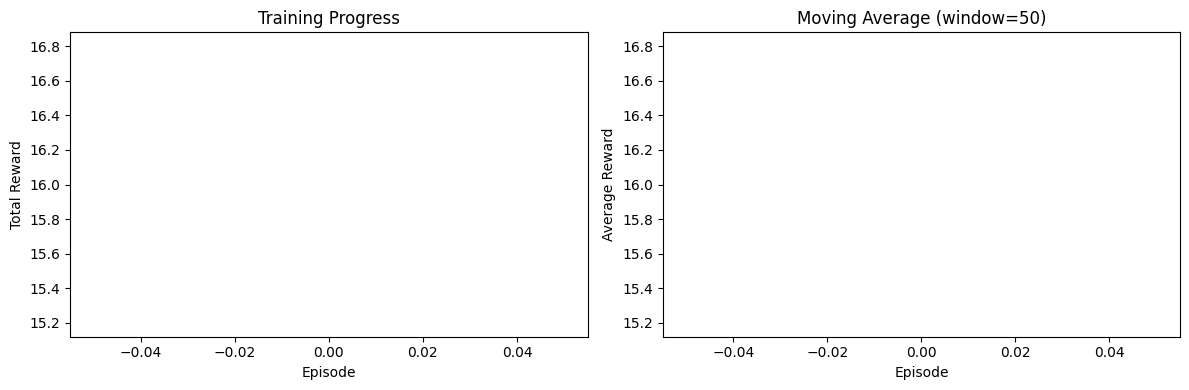

Testing trained agent...
Test Episode 1: Total Reward = 10.0, Steps = 10


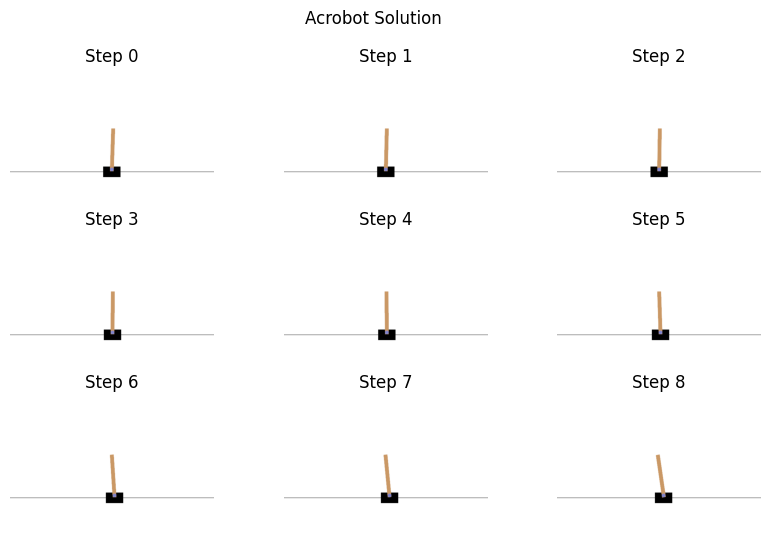

Test Episode 2: Total Reward = 9.0, Steps = 9
Test Episode 3: Total Reward = 10.0, Steps = 10
Test Episode 4: Total Reward = 9.0, Steps = 9
Test Episode 5: Total Reward = 10.0, Steps = 10


In [31]:
# Enhanced neural network for Acrobot
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, n_actions, hidden_size=128):
        super(PolicyNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim[0], hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions)
        )
        
    def forward(self, x):
        return self.network(x)

class ValueNetwork(nn.Module):
    """Value network for baseline (reduces variance)"""
    def __init__(self, state_dim, hidden_size=128):
        super(ValueNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim[0], hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
    def forward(self, x):
        return self.network(x)

# Create models
policy_net = PolicyNetwork(state_dim, n_actions)
value_net = ValueNetwork(state_dim)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=1e-3)
value_optimizer = optim.Adam(value_net.parameters(), lr=1e-3)

print("Models created successfully")

# Enhanced training functions with baseline
def get_cumulative_rewards(rewards, gamma=0.99):
    """Compute cumulative rewards with discounting"""
    cumulative_rewards = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        cumulative_rewards.insert(0, G)
    return np.array(cumulative_rewards)

def compute_advantages(rewards, states, value_net, gamma=0.99):
    """Compute advantages using value network as baseline"""
    states_tensor = torch.tensor(states, dtype=torch.float32)
    with torch.no_grad():
        values = value_net(states_tensor).squeeze().numpy()
    
    cumulative_rewards = get_cumulative_rewards(rewards, gamma)
    advantages = cumulative_rewards - values
    return advantages, cumulative_rewards

def get_loss_with_baseline(states, actions, rewards, policy_net, value_net, 
                          gamma=0.99, entropy_coef=0.01):
    """Enhanced loss function with value baseline"""
    states_tensor = torch.tensor(states, dtype=torch.float32)
    actions_tensor = torch.tensor(actions, dtype=torch.long)
    
    # Policy network outputs
    logits = policy_net(states_tensor)
    log_probs = torch.log_softmax(logits, dim=-1)
    probs = torch.softmax(logits, dim=-1)
    
    # Value network outputs
    values = value_net(states_tensor).squeeze()
    
    # Compute advantages
    advantages, cumulative_returns = compute_advantages(rewards, states, value_net, gamma)
    advantages_tensor = torch.tensor(advantages, dtype=torch.float32)
    returns_tensor = torch.tensor(cumulative_returns, dtype=torch.float32)
    
    # Policy loss
    log_probs_for_actions = log_probs[range(len(actions)), actions_tensor]
    policy_loss = -torch.mean(log_probs_for_actions * advantages_tensor)
    
    # Value loss (MSE between predicted values and actual returns)
    value_loss = torch.mean((values - returns_tensor) ** 2)
    
    # Entropy regularization
    entropy = -torch.sum(probs * log_probs, dim=-1)
    entropy_loss = -torch.mean(entropy)  # Negative because we want to maximize entropy
    
    # Total loss
    total_loss = policy_loss + 0.5 * value_loss - entropy_coef * entropy_loss
    
    return total_loss, policy_loss.item(), value_loss.item(), entropy_loss.item()

def generate_session(policy_net, env, max_steps=1000):
    """Generate session using current policy"""
    states, actions, rewards = [], [], []
    state = env.reset()[0]
    
    for step in range(max_steps):
        states.append(state)
        
        # Get action probabilities
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            logits = policy_net(state_tensor)
            probs = torch.softmax(logits, dim=-1).numpy()[0]
        
        # Sample action
        action = np.random.choice(n_actions, p=probs)
        actions.append(action)
        
        # Take action
        next_state, reward, done, truncated, info = env.step(action)
        rewards.append(reward)
        
        state = next_state
        
        if done or truncated:
            break
    
    return states, actions, rewards

# Training loop with early stopping
def train_acrobot(policy_net, value_net, env, episodes=1000, target_reward=-100):
    """Enhanced training function for Acrobot"""
    scores = []
    recent_scores = deque(maxlen=100)
    
    for episode in range(episodes):
        # Generate session
        states, actions, rewards = generate_session(policy_net, env)
        total_reward = sum(rewards)
        scores.append(total_reward)
        recent_scores.append(total_reward)
        
        # Compute loss and update networks
        policy_optimizer.zero_grad()
        value_optimizer.zero_grad()
        
        loss, policy_loss, value_loss, entropy_loss = get_loss_with_baseline(
            states, actions, rewards, policy_net, value_net
        )
        
        loss.backward()
        policy_optimizer.step()
        value_optimizer.step()
        
        # Print progress
        if episode % 100 == 0:
            avg_score = np.mean(recent_scores)
            print(f"Episode {episode}, Total Reward: {total_reward:.1f}, "
                  f"Avg Score: {avg_score:.1f}, Loss: {loss.item():.3f}")
            
            # Early stopping if solved
            if avg_score >= target_reward:
                print(f"Solved! Average score {avg_score:.1f} >= {target_reward}")
                break
    
    return scores

# Train the agent
print("Starting training...")
scores = train_acrobot(policy_net, value_net, env, episodes=2000, target_reward=-100)

# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(scores)
plt.title("Training Progress")
plt.xlabel("Episode")
plt.ylabel("Total Reward")

# Moving average
window = 50
moving_avg = [np.mean(scores[max(0, i-window):i+1]) for i in range(len(scores))]
plt.subplot(1, 2, 2)
plt.plot(moving_avg)
plt.title(f"Moving Average (window={window})")
plt.xlabel("Episode")
plt.ylabel("Average Reward")

plt.tight_layout()
plt.show()

# Test the trained agent
def test_agent(policy_net, env, episodes=5):
    """Test the trained agent"""
    for episode in range(episodes):
        state = env.reset()[0]
        total_reward = 0
        frames = []
        
        for step in range(1000):
            # Render first episode
            if episode == 0:
                frames.append(env.render())
            
            # Get action
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                logits = policy_net(state_tensor)
                action = torch.argmax(logits).item()
            
            next_state, reward, done, truncated, info = env.step(action)
            total_reward += reward
            state = next_state
            
            if done or truncated:
                break
        
        print(f"Test Episode {episode + 1}: Total Reward = {total_reward}, Steps = {step + 1}")
        
        # Display first episode
        if episode == 0 and len(frames) > 0:
            plt.figure(figsize=(10, 6))
            for i in range(min(9, len(frames))):
                plt.subplot(3, 3, i + 1)
                plt.imshow(frames[i * (len(frames) // 9)])
                plt.axis('off')
                plt.title(f"Step {i * (len(frames) // 9)}")
            plt.suptitle("Acrobot Solution")
            plt.show()

print("Testing trained agent...")
test_agent(policy_net, env)

env.close()